## Section 0. Ensure Dependencies

In [83]:
#install.packages('reshape2', dependencies = TRUE, repos = 'http://cran.us.r-project.org')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


In [1]:
library(tidytext)
library(magrittr)
library(dplyr)
library(stringr)
library(textclean)
library(ggplot2)
library(reshape2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Section 1. Data Preparation

### Step 1: Read Data

I use the ``replace_contraction()`` function to take contracted words (e.g. I'm, She'd) and make them complete words (e.g. I am, She would) for the convenience of analysis.

In [2]:
spooky <- read.csv('../data/spooky.csv', as.is = TRUE)
spooky$author <- spooky$author %>% as.factor()
spooky$text <- spooky$text %>% replace_contraction()

### Step 2: Process Data - Split sentences into words

We use `unnest_tokens()` to process the data into tidy format for ease of analysis. For the subsequent analyses, we need:
- One dataframe that drops punctuations, turns words into lower case, but does not remove stop words
- One dataframe that drops punctuations, removes everything with higher case, removes all stop words, then turned to lower case

In [3]:
sws <- spooky_with_stopwords <- spooky %>% 
    unnest_tokens(word, text)
srw <- spooky_rare_words <- spooky %>% 
    unnest_tokens(word, text, to_lower = FALSE) %>%
    drop_row('word', c('[A-Z]')) %>% 
    anti_join(stop_words, by = "word")

## Section 2. "Gothic" Keywords Comparison

In this section, we will compare the relative frequency of British Gothic keywords identified by [Jones (2010)](https://www.era.lib.ed.ac.uk/bitstream/handle/1842/5351/Dissertation_Final.pdf;sequence=1), which include 
- Pronouns (especially first-person and second-person)
    - Examples: I, me, myself, you, yourself, etc.
- Vocatives (names, titles, etc.)
    - Examples: Adrian, Miss, Mr, etc.
- Body parts 
    - Examples: Arms, foreheads, lips, etc.
- "Gothic" words (words related to a dark and supernatural atmosphere)
    - Examples: Fear, curiosity, silence, dark, dead, spirit

Because the identification of vocatives, especially names, deserves attention as a project on its own, I decide to examine the other three categories of keywords. Jones (2010) identified Gothic keywords as those that appear more frequently in Gothic writing than in a general English corpus. In this project, we choose compare the frequencies of these keywords in our dataset against the "Gothic" pattern he discovered. 

### Step 1: Assumptions, metric definition and method

Prior to the analysis, we assume: **The dataset is a representative sample of all three authors' writings**. 

In this analysis, we compare simple word frequencies as opposed to TF-IDF because 
1. We examine common words as opposed to "special words".
2. The dataset is not valid as a "corpus" in this sense because the three authors are from different regions and time periods, which can be associated with their differences in styles. To obtain an accurate measure of the IDF part, we need representative corpi of text from their respective period and locale. There was plan to use Corpus of Historical American English for EAP and HPL, and Corpus of Late Modern English Texts for MWS. However, I had difficulty contacting the owner of the latter corpus, and I couldn't find another appropriate early-19th-century British corpus, I will limit my analysis to simple word frequencies, assuming that MWS' patterns are representative of those of the early-19th-century British Gothic fiction. 

Because in our dataset, the three authors have different numbers of sentences, we adjust the word frequencies for each author by the total number of words in the dataset from each author. 
$$
    \text{rel_freq}(\text{word}, \text{author}) 
    = \frac{\text{# occurrence of word}}{\text{total # words by author}}
$$

In [4]:
# For pronouns: dataset contains stop words
# Word count by author
author_count = sws %>%
    group_by(author) %>%
    count()
# Count of every word for each author
author_word_count = sws %>%
    group_by(author, word) %>%
    count()

In [5]:
author_rel_freq <- author_word_count %>% 
    select(author, word, count = n) %>%
    left_join(author_count %>% 
                 select(author, total_count = n),
              by = 'author') %>% 
    mutate(rel_freq = count / total_count) %>%
    select(.data$author, .data$word, .data$rel_freq)
author_rel_freq <- author_rel_freq[order(-author_rel_freq$rel_freq),]

**Limitation of relative frequency and remedy**


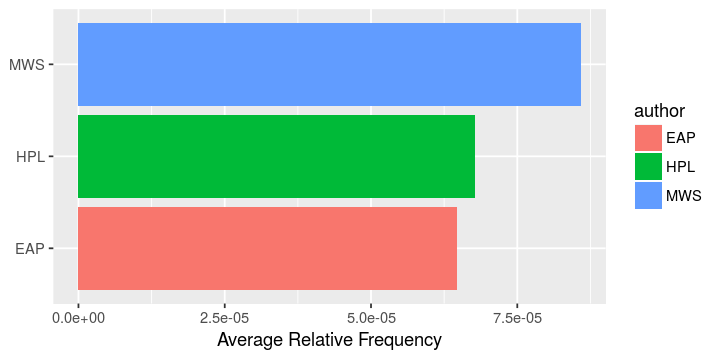

In [6]:
options(repr.plot.width = 6, repr.plot.height = 3)
# Compare the average relative frequency of each author
author_rel_freq %>%
    group_by(author) %>%
    summarise(mean_rel_freq = mean(rel_freq)) %>%
    ggplot(aes(x = author, y = mean_rel_freq, fill = author)) + 
    geom_bar(position="dodge", stat="identity") + 
    coord_flip() + 
    xlab(NULL) +
    ylab('Average Relative Frequency')

From the graph above, however, we can notice that Mary Shelley has the highest average relative frequency, while Edgar Allan Poe has the lowest. The average value is lower when an author uses a wider range of words, which may "slim out" the relative frequency for each term, resulting in a skewed comparison. On the other hand, if the excess number of words were rarely used at all, it may not have a significant impact on the relative frequency of common words such as pronouns, which we examine at this moment. 

Therefore, I decide to compare both the rankings and relative frequecies of words. Because rankings are done in descending order, we introduce the **inverse ranking** to turn ranking into an increasing variable as well as highlight the words with higher rankings. Inverse ranking is obtained as 
$$
    \text{inverse_ranking}(\text{rank}) = \frac{1}{\text{rank}}
$$

In [7]:
# Obtain rankings
author_rel_freq$rank <- NA
EAP_words = author_rel_freq[author_rel_freq$author == 'EAP',] 
HPL_words = author_rel_freq[author_rel_freq$author == 'HPL',]
MWS_words = author_rel_freq[author_rel_freq$author == 'MWS',]

author_rel_freq[author_rel_freq$author == 'EAP','rank'] <- 1:nrow(EAP_words)
author_rel_freq[author_rel_freq$author == 'HPL','rank'] <- 1:nrow(HPL_words)
author_rel_freq[author_rel_freq$author == 'MWS','rank'] <- 1:nrow(MWS_words)

### Step 2: Pronouns

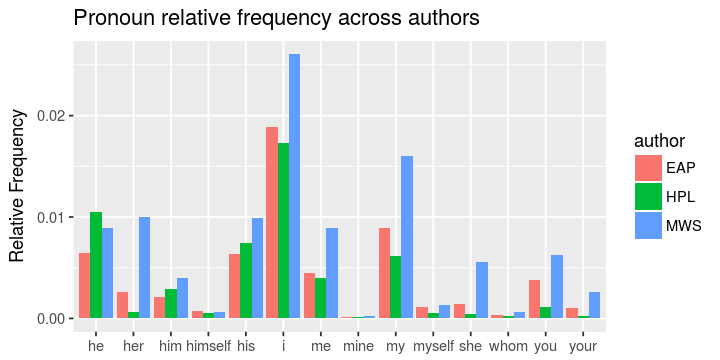

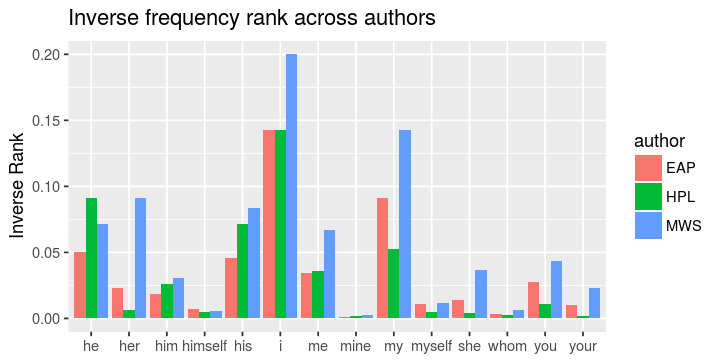

In [8]:
pronouns <- c('i', 'my', 'me', 'myself', 'you', 'your', 'he', 'his', 'him', 'himself', 
              'she', 'her', 'mine', 'whom')
author_pronoun_rel_freq <- author_rel_freq[author_rel_freq$word %in% pronouns,]

options(repr.plot.width = 6, repr.plot.height = 3)
# Relative Frequency plot
ggplot(author_pronoun_rel_freq, aes(x=word, y=rel_freq, fill = author)) + 
    geom_bar(position="dodge", stat="identity") + 
    ggtitle('Pronoun relative frequency across authors') + 
    ylab('Relative Frequency') +
    xlab(NULL)
# Inverse Ranking plot
ggplot(author_pronoun_rel_freq, aes(x=word, y=1/rank, fill = author)) + 
    geom_bar(position="dodge", stat="identity") +
    ggtitle('Inverse frequency rank across authors') + 
    ylab('Inverse Rank') +
    xlab(NULL)

In the figure for inverse rank, higher value denotes higher rank in word frequency. The trends illustrated by the two graphs are very close to each other. 

From the graphs above, Mary Shelley far more frequently uses first-person (I), second-person (you) and third-person feminine (she) pronouns. H.P. Lovecraft uses very few second-person (you) and third-person feminine (she) pronouns, but relatively many third-person masculine pronouns (he). The latter may be due to his tendency to avoid women in his literary works. 

Overall, the frequency and rankings of first-person pronouns are relatively high for all authors. This suggests that they tend to write in first-person narratives, which is a characteristic for Gothic writing, because the first-person limits the reader's knowledge and creates suspense, which much amplifies the genre's appeal (Jones). 

However, as the genre develops over time, **Gothic authors can deviate from this general pattern**. Lovecraft who lives in early 20-th century, for example, uses fewer first-person pronouns but still many third-person pronouns compared to the other two authors, who lived in early 19-th century. It will be interesting to compare the authors' general writing styles. 

### Step 2: Body parts and Gothic words

Despite having the operative function, body parts and Gothic words are reasonably rare compared to pronouns and vocative (names, titles) words, which should be mentioned every few sentences. Therefore, we choose to eliminate stop words and all words with capitalized letters (most of which, we assume, are proper names and titles). 

For this part of the analysis, we examine the top 30 most frequent words for each author from our remaining dataset. We do not include the inverse rank initially because different vocabulary repertoires by the authors do not warrant a rank comparison. After we uncover more information, however, we may consider examining ranks. 

In [9]:
# For body parts and Gothic words: stop words and capitalized words removed
# Word count by author
author_count = srw %>%
    group_by(author) %>%
    count()
# Count of every word for each author
author_word_count = srw %>%
    group_by(author, word) %>%
    count()

In [10]:
# Compute relative frequency
author_rel_freq <- author_word_count %>% 
    select(author, word, count = n) %>%
    left_join(author_count %>% 
                 select(author, total_count = n),
              by = 'author') %>% 
    mutate(rel_freq = count / total_count) %>%
    select(.data$author, .data$word, .data$rel_freq)
author_rel_freq <- author_rel_freq[order(-author_rel_freq$rel_freq),]

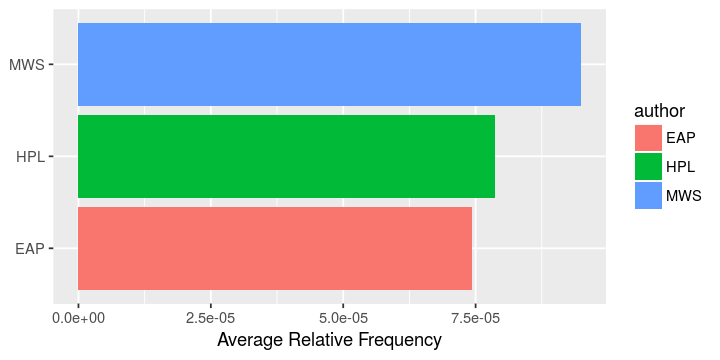

In [13]:
# Compare the average relative frequency of each author
options(repr.plot.width = 6, repr.plot.height = 3)
author_rel_freq %>%
    group_by(author) %>%
    summarise(mean_rel_freq = mean(rel_freq)) %>%
    ggplot(aes(x = author, y = mean_rel_freq, fill = author)) + 
    geom_bar(position="dodge", stat="identity") + 
    coord_flip() + 
    xlab(NULL) +
    ylab('Average Relative Frequency')

The figure above illustrates that the difference in average relative frequency does not significantly change with the removal of stop words and capitalized words. We should still look at the ranking information. 

In [24]:
# Obtain rankings
author_rel_freq$rank <- NA
EAP_words = author_rel_freq[author_rel_freq$author == 'EAP',] 
HPL_words = author_rel_freq[author_rel_freq$author == 'HPL',]
MWS_words = author_rel_freq[author_rel_freq$author == 'MWS',]

author_rel_freq[author_rel_freq$author == 'EAP','rank'] <- 1:nrow(EAP_words)
author_rel_freq[author_rel_freq$author == 'HPL','rank'] <- 1:nrow(HPL_words)
author_rel_freq[author_rel_freq$author == 'MWS','rank'] <- 1:nrow(MWS_words)

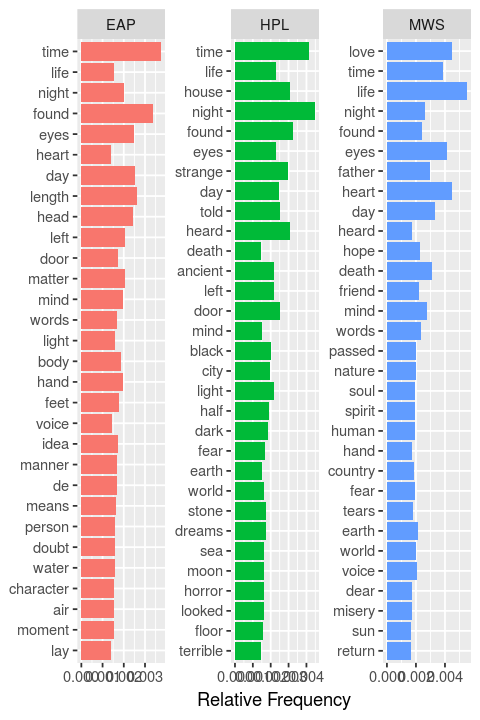

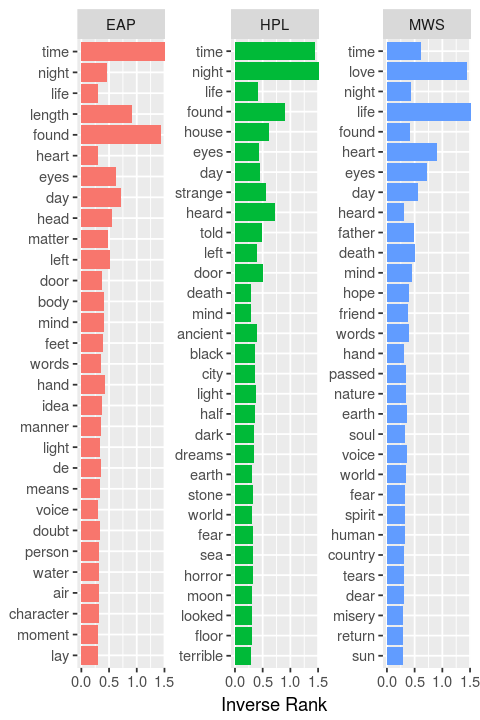

In [28]:
rel_freq <- author_rel_freq[order(-author_rel_freq$rel_freq),] %>% 
    group_by(author) %>%
    top_n(30, rel_freq) %>%
    ungroup()

options(repr.plot.width = 4, repr.plot.height = 6)
ggplot(rel_freq) +
  geom_col(aes(reorder(word, rel_freq), rel_freq, fill = author)) +
  labs(x = NULL, y = "Relative Frequency") +
  theme(legend.position = "none") +
  facet_wrap(~ author, ncol = 3, scales = "free") +
  coord_flip()

options(repr.plot.width = 4, repr.plot.height = 6)
ggplot(rel_freq) +
  geom_col(aes(reorder(word, 1/rank), 1/log(rank), fill = author)) +
  labs(x = NULL, y = "Inverse Rank") +
  theme(legend.position = "none") +
  facet_wrap(~ author, ncol = 3, scales = "free") +
  coord_flip()

## Section 3. Gothic keywords comparison

## Section 4. Statistical Test

## Section 5. k-means on sentence sentiments